In [13]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings

import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import rcParams

warnings.filterwarnings("ignore")

plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 25})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Using the summary file for a galaxy's stellar mass, age, and metallicity maps

* For a given Illustris or TNG galaxy, we have measured basic properties of their stellar mass, age, and metallicity distributions. 
* Each galaxy has data for the 3 primary projections: `xy`, `xz`, `yz`. 
    - We treat them as independent measurement. Result for each projection is saved in its own file.
* Each galaxy has three "components":
    - `ins`: in-situ stellar component, meaning the stars formed in the halo of the main progenitor.
    - `exs`: ex-situ stellar component, meaning the stars accreted from other halos.
    - `gal`: the whole galaxy, a combination of `ins` and `exs`.

In [2]:
data_dir = '/Users/song/data/massive/simulation/riker/tng/sum'

* Naming of the file, for example: `tng100_z0.4_hres_158_181900_xy_sum.npy`
    - `tng100`: Simulation used. `ori` for original Illustris; `tng` for Illustris TNG. Number indicates the volume of the simulation. e.g. `tng100`, `tng300`.
    - `z0.4`: the snapshot is at z=0.4.
    - `hres`: high-resolution map, which has a 1 kpc pixel; also have `lres` for low-resolution, which has a 5.33 kpc pixel.
    - `158_181900` in the format of `INDEX_CATSHID`: `INDEX` is just the index in the dataset; `CATSHID` is the subhalo ID from the simulation, which is a unique number to indentify halo or galaxy.
    - `xy`: projection used in this data.
    
* Let's try read in the summary files in all 3 projections for one galaxy:

In [3]:
xy_sum = np.load(os.path.join(data_dir, 'tng100_z0.4_hres_15_31188_xy_sum.npy'))
xz_sum = np.load(os.path.join(data_dir, 'tng100_z0.4_hres_15_31188_xz_sum.npy'))
yz_sum = np.load(os.path.join(data_dir, 'tng100_z0.4_hres_15_31188_yz_sum.npy'))

* The structure of the summary file is just a dictionary that contains the results from different steps of analysis, each of which is also a dictionary of data.
* For each projection, there are 4 components:
    - **info**: basic info of the galaxy from simulation, including subhalo ID, stellar mass, halo mass (`M200c`), and average age and metallicity values. This can be used to identify and match galaxies. Also includes information about the size and pixel scale of the map.
    - **geom**: basic geometry information of the galaxy on the stellar mass map. `x`, `y` for centroid; `ba` for axis ratio, `pa` for position angle in degree (`theta` is the same, but in radian).
    - **aper**: stellar mass, age, and metallicity profiles for each component measured in a series of apertures. Will explain more later.
    - **prof**: 1-D profile information from `Ellipse` profile fitting process. Will explain in details below.

In [7]:
# Take a look at the basic information 
xy_sum['info']

{'catsh_id': 31188,
 'cen_flag': True,
 'logms': 12.05664465877549,
 'logm200c': 14.000733947873849,
 'age': 6.34057143397595,
 'metallicity': 0.018275347585988536,
 'pix': 1.0,
 'proj': 'xy',
 'logms_map_ins': 11.62021802229474,
 'logms_map_exs': 11.75278172198268,
 'logms_map_gal': 11.992568307990515,
 'img_h': 300,
 'img_w': 300,
 'img_cen_x': 150.0,
 'img_cen_y': 150.0}

In [9]:
# Basic geometric information of the galaxy
xy_sum['geom']

{'x': 149.65675377343484,
 'y': 149.54019325483404,
 'ba': 0.7629101942780893,
 'theta': 1.0879850387573242,
 'pa': 62.33695089417198,
 'objs': array([(1.e+08, 1054, 1014, 133, 167, 130, 169, 149.65675377, 149.54019325, 29.4510336, 39.87022463, 7.53093875, 0., 0., 0., 6.61950636, 5.05008888, 1.08798504, 0.03567792, 0.02635429, -0.01347814, 5.82019908e+11, 5.82982238e+11, 9.7172777e+09, 2.07078769e+10, 150, 150, 150, 150, 0)],
       dtype=[('thresh', '<f8'), ('npix', '<i8'), ('tnpix', '<i8'), ('xmin', '<i8'), ('xmax', '<i8'), ('ymin', '<i8'), ('ymax', '<i8'), ('x', '<f8'), ('y', '<f8'), ('x2', '<f8'), ('y2', '<f8'), ('xy', '<f8'), ('errx2', '<f8'), ('erry2', '<f8'), ('errxy', '<f8'), ('a', '<f8'), ('b', '<f8'), ('theta', '<f8'), ('cxx', '<f8'), ('cyy', '<f8'), ('cxy', '<f8'), ('cflux', '<f8'), ('flux', '<f8'), ('cpeak', '<f8'), ('peak', '<f8'), ('xcpeak', '<i8'), ('ycpeak', '<i8'), ('xpeak', '<i8'), ('ypeak', '<i8'), ('flag', '<i8')]),
 'n_objs': 1}

### Aperture measurements

* It is easier to see the content of the summary using a astropy table:
* Key information:
    - `rad_inn`, `rad_out`, `rad_mid`: inner & outer edges, and the middle point of the radial bins.
    - `maper_[gal/ins/exs]`: aperture masses enclosed in different radius (using elliptical apertures). 
    - `mprof_[gal/ins/exs]`: stellar mass in each radial bin.
    - `age_[gal/ins/exs]_w`: mass-weighted stellar age. 
    - `met_[gal/ins/exs]_w`: mass-weighted stellar metallicity.
    - There are also flags to indicate if the age and metallicity values can be trust. Any value >0 means there is an issue.
* Notice that the `age` and `met` values can be `NaN` in the outskirts.
* It is also possible that `mprof` has 0.0 value in an outer bin for some compact galaxies.

In [12]:
Table(xy_sum['aper'])

rad_inn,rad_out,rad_mid,maper_gal,maper_ins,maper_exs,age_gal_w,age_gal,age_gal_flag,mprof_gal,age_ins_w,age_ins,age_ins_flag,mprof_ins,age_exs_w,age_exs,age_exs_flag,mprof_exs,met_gal_w,met_gal,met_gal_flag,met_ins_w,met_ins,met_ins_flag,met_exs_w,met_exs,met_exs_flag
float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,int16,float64,float64,int16
0.5,0.6864167170609846,0.5932083585304924,20509187510.857147,5303878238.040817,15205309210.122452,6.729575684706976,6.743436317443848,0,9110119465.795918,7.4037522686932355,7.403566875457765,0,2360431736.163265,6.493809561591244,6.510664463043215,0,6749687682.612244,0.04281721876282442,0.04256599783897401,0,0.03793209927108967,0.03787108555436135,0,0.04452559361371791,0.044217789322137845,0
0.6864167170609846,0.9423358189215597,0.8143762679912722,37987487284.24492,9829837865.795923,28157649230.36736,6.729650943326044,6.743485709031423,0,17478299773.387756,7.403173110523208,7.402960777282714,0,4525959627.755102,6.494300915367896,6.511170446872711,0,12952340020.244896,0.042794784216035206,0.04254453411946694,0,0.03792801453152969,0.037867901769156255,0,0.044495389101798385,0.04418831535925467,0
0.9423358189215597,1.293670118386223,1.1180029686538913,65241073569.95922,17195715949.7143,48045357113.46941,6.773119747233144,6.820914242002699,0,27253586285.71429,7.37271073817431,7.359272283977931,0,7365878083.918367,6.551047305224812,6.62477838198344,0,19887707883.102043,0.041855756009517284,0.04087860874003833,0,0.03730882729461805,0.03697494429846604,0,0.04353981830610233,0.04228987354371282,0
1.293670118386223,1.775993591245133,1.5348318548156779,99205170604.40819,27620399232.000008,71584770904.81635,6.904666219148236,6.984097995977292,0,33964097034.448982,7.2940076695119,7.27461373943022,0,10424683282.285717,6.732242124029262,6.869148342088722,0,23539413791.346943,0.039044310285612394,0.03728321624984002,0,0.03542186270021654,0.03487465408598555,0,0.04064855023153133,0.038234456752737365,0
1.775993591245133,2.438143380847665,2.107068486046399,142758824385.30615,42303603291.42859,100455221224.4898,7.019381588072945,7.051033268491907,0,43553653780.89798,7.170855451759946,7.123150808265411,0,14683204059.428577,6.942343442889106,7.026449907256895,0,28870450319.673477,0.03612064707158822,0.034855437033013054,0,0.03326209526112602,0.03265640892492361,0,0.037574475506845235,0.035853935983480814,0
2.438143380847665,3.3471647504108475,2.892654065629256,189430708965.87753,58201515860.89796,131229193286.53061,6.976548338805555,6.947740500535418,0,46671884580.57145,6.696713408493336,6.6251306231428915,0,15897912569.469398,7.12111173373038,7.139371351691764,0,30773972062.04083,0.03292592551330163,0.03187739545615709,0,0.0289338229545947,0.0284147020701955,0,0.034988255498958336,0.03360187954049769,0
3.3471647504108475,4.59509967887853,3.9711322146446886,239613395936.65308,77568408227.26532,162044987798.20407,6.666836507422195,6.612743912022447,0,50182686970.77553,5.804783774516776,5.745700365094454,0,19366892366.367367,7.208613252187982,7.195145434084682,0,30815794511.67349,0.028897551909047543,0.02842787533042299,0,0.024820064358593123,0.02464844143655051,0,0.031460142535225576,0.0307651162115435,0
4.59509967887853,6.308306472287569,5.451703075583049,299036225263.0204,105267652016.32657,193768573051.42862,6.073630444556098,6.039830633805031,0,59422829326.36738,4.80752212687263,4.7829306946087655,0,27699243789.06123,7.179124776292296,7.166201515423786,0,31723585253.22451,0.025674371570883824,0.02549848151490867,0,0.022458172089187763,0.022396369769306704,0,0.028482575703816036,0.028159219565323353,0
6.308306472287569,8.660254037844387,7.484280255065978,371215501513.143,143771179020.4082,227444322345.1429,5.550484583680356,5.538915885461344,0,72179276250.12247,4.184927496777226,4.189573974165216,0,38503527004.081665,7.111808829236858,7.101917754038879,0,33675749293.714287,0.02309

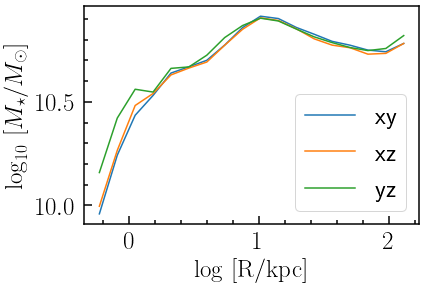

In [26]:
# Check the differences of the three projections in term of mass profiles
# They are very similar, but not the same

plt.plot(np.log10(xy_sum['aper']['rad_mid']), np.log10(xy_sum['aper']['mprof_gal']), label='xy')
plt.plot(np.log10(xz_sum['aper']['rad_mid']), np.log10(xz_sum['aper']['mprof_gal']), label='xz')
plt.plot(np.log10(yz_sum['aper']['rad_mid']), np.log10(yz_sum['aper']['mprof_gal']), label='yz')
plt.legend(loc='best')
_ = plt.xlabel(r'$\log\ [\rm R/kpc]$')
_ = plt.ylabel(r'$\log_{10}\ [M_{\star}/M_{\odot}]$')

### Summary of `Ellipse` results.

* We use the `Ellipse` code to extract the shape and mass density profiles for each component. So, if everything goes well, the `prof` summary dictionary should contain 6 profiles.
    - `[gal/ins/exs]_shape`: We first run `Ellipse` allowing the shape and position angle to change along the radius. From this step, we can estimate the profile of ellipticity and position angle.
    - `[gal/ins/exs]_mprof`: Then we fix the isophotal shape at the flux-weighted value and run `Ellipse` to extract 1-D mass density profiles along the major axis.
    - Each profile itself is a small table, which can be visualize better using `astropy.table`
    - For the `ins` and `exs` components, their mass density profiles are extracted using the average shape of the **whole galaxy**, which can be different from the average shape of these two components.
    
* In each profile, the useful information are:
    - `r_pix` and `r_kpc`: radius in pixel and kpc unit.
    - `ell` and `ell_err`: ellipticity and its error
    - `pa` and `pa_err`: position angle (in degree) and its error. **Notice**: need to be normalized sometimes.
    - `pa_norm`: position angle profile after normalization
    - `growth_ori`: total stellar mass enclosed in each isophote. This is from integrating the profile using average values at each radii, could show small difference with the values from "aperture photometry".
    - `intens` and `int_err`: average stellar mass per pixel at each radii. When divided by the pixel are in unit of kpc^2, it will give the surface mass density profile and the associated error.
    - The amplitudes of first 4 Fourier deviations are available too: `a1/a2/a3/a4` & `b1/b2/b3/b4`. These values should be interpreted as relative deviation. Their errors are available too. **Please be cautious when using these values.**

* In some rare cases, `Ellipse` can fail to get useful profile. This is usually caused by on-going mergers and mostly happens for the `shape` profile. 
    - The corresponding field will be `None` when `Ellipse` failed. Please be careful!
    - It is safe to assume these failed cases are "weird" and exclude them from most of the analysis.

In [38]:
# Check out the 1-D shape profile for the whole galaxy
Table(xy_sum['prof']['gal_mprof'])

index,sma,intens,int_err,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,stop,tflux_e,tflux_c,pa_norm,growth_ori,sbp_err,r_pix,r_kpc,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.563415,13458240000.0,871975296.0,0.24,0.2687646,-27.66,37.77155,151.0,0.08340378,150.0,0.09556198,0.0,14648390000.0,14648390000.0,-27.66,0.0,0.06816111617029463,0.563415,0.563415,0.26513486988423357,2.82375373916497,0.19901907702278862,2.7283848641467503,0.5598410218505669,2.8220178102743128,0.24372708195077347,2.7177059428323873,0.16744529580188797,2.8090953048604654,1.0888577349855904,2.686436080987804,0.03865664059437417,2.8314913067852574,-0.10868720795712603,2.667925853064796
2,0.676098,13181960000.0,1023525000.0,0.24,0.2824184,-27.66,39.69042,151.0,0.105169,150.0,0.1205001,0.0,14648390000.0,14648390000.0,-27.66,4395951996.246354,0.08119019105225078,0.676098,0.676098,0.2767667613738009,3.217973092020746,0.17160609759780365,3.109290211657204,0.5840180277163862,3.2174950141518313,0.21934533827095898,3.098564881472401,0.16434019845763487,3.2074051039193834,1.1297340812021737,3.0673534258200297,0.0389158294728491,3.2330495359745304,-0.10789721734186679,3.0462875087402574
3,0.8113177,12833670000.0,1196492000.0,0.24,0.2973199,-27.66,41.78465,151.0,0.1328618,150.0,0.1522298,0.0,14648390000.0,14648390000.0,-27.66,10558873867.461956,0.09677954460492089,0.8113177,0.8113177,0.2892793155720959,3.6685259854611862,0.1418818656047324,3.5446261460751023,0.6100454375868422,3.6693115912512093,0.19288513622301656,3.5336809201992394,0.16097031419011487,3.6621265486751375,1.17375730376836,3.5022192263306393,0.03918581204933671,3.691470522588024,-0.10701858864823109,3.4782272148171036
4,0.9735813,12391430000.0,1392288000.0,0.24,0.3150696,-27.66,44.27916,151.0,0.1689523,150.0,0.1935813,0.0,14648390000.0,14648390000.0,-27.66,19127666761.09131,0.1156123786681782,0.9735813,0.9735813,0.30421729767031275,4.191588040276659,0.11068406325814453,4.0500223524676615,0.6411938741443904,4.193640307915561,0.16546212618712394,4.038628449437478,0.15820200527310183,4.189352699721265,1.2270764457234955,4.006424101373868,0.03968224766028272,4.222975356761928,-0.10662457317266855,3.9790288156411022
5,1.168298,11770900000.0,1572467000.0,0.24,0.2184988,-27.66,30.70731,151.0,0.1406008,150.0,0.1610969,0.0,41395570000.0,66260000000.0,-27.66,30848846601.04715,0.13613940249488365,1.168298,1.168298,0.2069198007616526,2.7328847354405683,0.1230830289268279,2.6405848655311144,0.4364564191122043,2.73366938152935,0.15961703043530945,2.632623321018594,0.0958049741753515,2.7261327231212187,0.9369842448305847,2.6070960253708133,0.030224249128698363,2.7479478299291342,-0.08770435654329164,2.589208435789388
6,1.401957,10678660000.0,1555424000.0,0.24,0.1093468,-27.66,15.36734,151.0,0.08443569,150.0,0.09674432,0.0,66260000000.0,66260000000.0,-27.66,46161094462.72128,0.14763674730839682,1.401957,1.401957,0.09618424865907313,1.7951205584917074,0.2603568799250999,1.7344925900514043,0.20473686539659283,1.7948916320137387,0.27110203625351076,1.728546171298674,0.059093947087933835,1.7956237688432797,0.4385536515321007,1.717217733838897,0.02061769092205063,1.8099434409651871,-0.06988526312440228,1.7053891883022492
7,1.682349,9164958000.0,1354035000.0,0.24,0.07952047,-27.66,11.17562,151.0,0.07368518,150.0,0.08442665,0.0,85613960000.0,103400700000.0,-27.66,65085272324.14235,0.1496092175745254,1.682349,1.682349,0.05069662496144187,1.9819109987775458,0.5037251078040904,1.9149743488420978,0.11119889230130996,1.9783026824840155,0.49856008471476954,1.9051776297807048,0.0512469746597328,1.9831914359108873,0.29461249415793395,1.896595235255742,0.02372827721002244,1.998923597006092,-0.09408059161413393,1.88345257

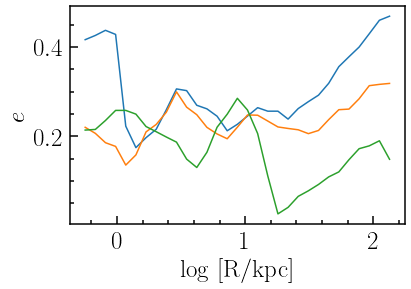

In [27]:
# Check the ellipticity profiles of the three projections

plt.plot(np.log10(xy_sum['prof']['gal_shape']['r_kpc']), xy_sum['prof']['gal_shape']['ell'], label='xy')
plt.plot(np.log10(xz_sum['prof']['gal_shape']['r_kpc']), xz_sum['prof']['gal_shape']['ell'], label='xz')
plt.plot(np.log10(yz_sum['prof']['gal_shape']['r_kpc']), yz_sum['prof']['gal_shape']['ell'], label='yz')
_ = plt.xlabel(r'$\log\ [\rm R/kpc]$')
_ = plt.ylabel(r'$e$')

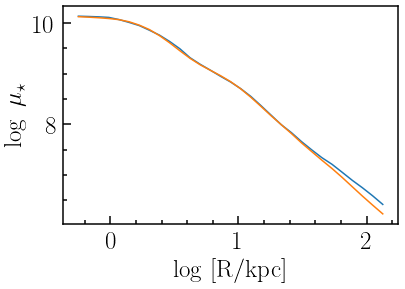

In [28]:
# And the mass profiles derived using varied and fixed shape can be different

plt.plot(np.log10(xy_sum['prof']['gal_shape']['r_kpc']), np.log10(xy_sum['prof']['gal_shape']['intens']), 
         label='Varied Shape')
plt.plot(np.log10(xy_sum['prof']['gal_mprof']['r_kpc']), np.log10(xy_sum['prof']['gal_mprof']['intens']), 
         label='Fixed Shape')

_ = plt.xlabel(r'$\log\ [\rm R/kpc]$')
_ = plt.ylabel(r'$\log\ \mu_{\star}$')

### Organize the data better

* For certain project, you can organize information from the summary file into a structure that is easier to use.
* Using the 3-D galaxy shape project as example:

In [41]:
xy_sum_for3d = {
    # Subhalo ID
    'catsh_id': xy_sum['info']['catsh_id'],
    # Stellar mass of the galaxy
    'logms': xy_sum['info']['logms'],
    # Basic geometry of the galaxy
    'aper_x0': xy_sum['geom']['x'], 
    'aper_y0': xy_sum['geom']['y'],
    'aper_ba': xy_sum['geom']['ba'], 
    'aper_pa': xy_sum['geom']['pa'],
    # Aperture mass profile
    'aper_rkpc': xy_sum['aper']['rad_mid'], 
    # Total mass enclosed in the aperture
    'aper_maper': xy_sum['aper']['maper_gal'],
    # Stellar mass in the bin
    'aper_mbins': xy_sum['aper']['mprof_gal'],
    # 1-D profile with varied shape
    'rkpc_shape': xy_sum['prof']['gal_shape']['r_kpc'],
    # This is the surface mass density profile and its error
    'mu_shape': xy_sum['prof']['gal_shape']['intens'] / (xy_sum['info']['pix'] ** 2.0),
    'mu_err_shape': xy_sum['prof']['gal_shape']['int_err'] / (xy_sum['info']['pix'] ** 2.0),
    # This is the ellipticity profiles
    'e_shape': xy_sum['prof']['gal_shape']['ell'],
    'e_err_shape': xy_sum['prof']['gal_shape']['ell_err'],
    # This is the normalized position angle profile
    'pa_shape': xy_sum['prof']['gal_shape']['pa_norm'],
    'pa_err_shape': xy_sum['prof']['gal_shape']['pa_err'],
    # Total mass enclosed by apertures
    'maper_shape': xy_sum['prof']['gal_shape']['growth_ori'],
    # 1-D profile using fixed shape
    'rkpc_prof': xy_sum['prof']['gal_mprof']['r_kpc'],
    # This is the surface mass density profile and its error
    'mu_mprof': xy_sum['prof']['gal_mprof']['intens'] / (xy_sum['info']['pix'] ** 2.0),
    'mu_err_mprof': xy_sum['prof']['gal_mprof']['int_err'] / (xy_sum['info']['pix'] ** 2.0),
    # Total mass enclosed by apertures
    'maper_mprof': xy_sum['prof']['gal_mprof']['growth_ori'],
    # Fourier deviations
    'a1_mprof': xy_sum['prof']['gal_mprof']['a1'], 
    'a1_err_mprof': xy_sum['prof']['gal_mprof']['a1_err'], 
    'a2_mprof': xy_sum['prof']['gal_mprof']['a2'], 
    'a2_err_mprof': xy_sum['prof']['gal_mprof']['a2_err'], 
    'a3_mprof': xy_sum['prof']['gal_mprof']['a3'], 
    'a3_err_mprof': xy_sum['prof']['gal_mprof']['a3_err'], 
    'a4_mprof': xy_sum['prof']['gal_mprof']['a4'], 
    'a4_err_mprof': xy_sum['prof']['gal_mprof']['a4_err'], 
    'b1_mprof': xy_sum['prof']['gal_mprof']['b1'], 
    'b1_err_mprof': xy_sum['prof']['gal_mprof']['b1_err'], 
    'b2_mprof': xy_sum['prof']['gal_mprof']['b2'], 
    'b2_err_mprof': xy_sum['prof']['gal_mprof']['b2_err'], 
    'b3_mprof': xy_sum['prof']['gal_mprof']['b3'], 
    'b3_err_mprof': xy_sum['prof']['gal_mprof']['b3_err'], 
    'b4_mprof': xy_sum['prof']['gal_mprof']['b4'], 
    'b4_err_mprof': xy_sum['prof']['gal_mprof']['b4_err'] 
}

### Visualizations

* `riker` provides a few routines to help you visualize the `aper` and `prof` result. 
* You can `git clone git@github.com:dr-guangtou/riker.git` and the `python3 setup.py develop` to install it.
* Unfortunately, now it still depends on some of my personal code that is still under development. But it is fine to just make a few plots.


In [29]:
from riker import visual

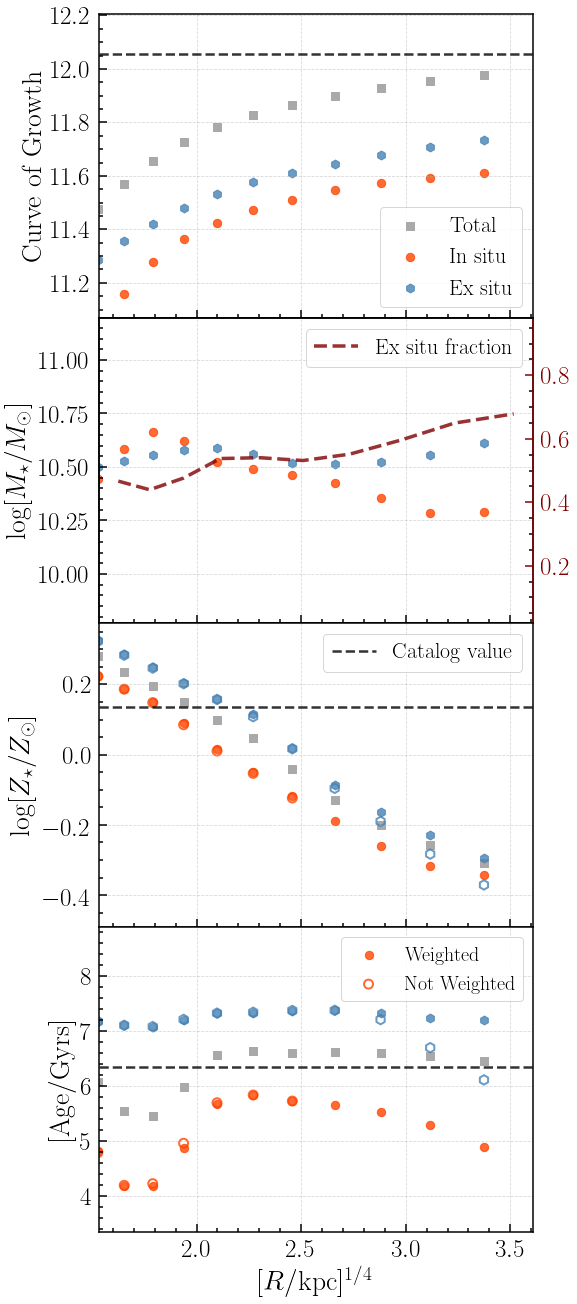

In [30]:
# Summary plot of the aperture measurements
_ = visual.show_aper(xy_sum['info'], xy_sum['aper'])

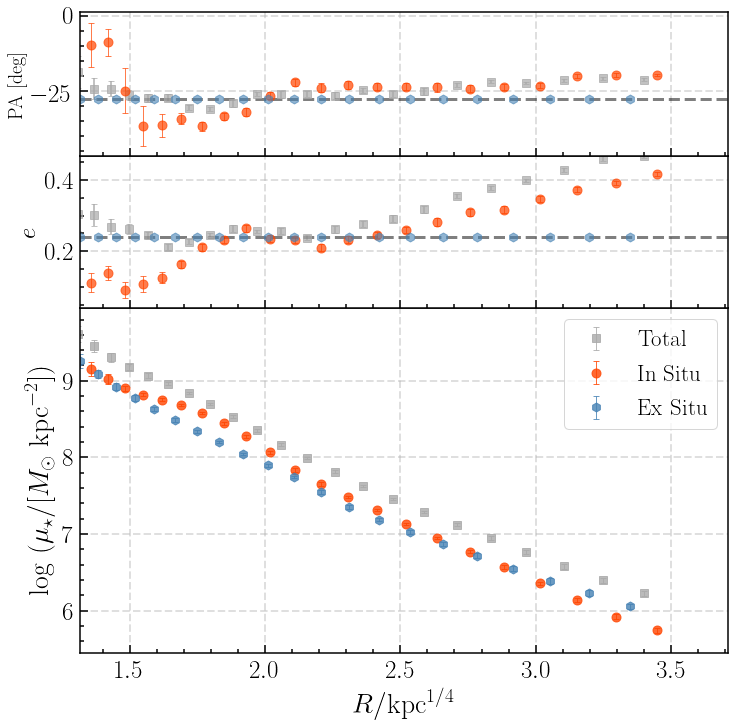

In [31]:
# Fake some empty stellar mass maps structure
maps_fake = {'mass_gal': None, 'mass_ins': None, 'mass_exs': None}
# Organize the data
ell_plot = visual.prepare_show_ellipse(xy_sum['info'], maps_fake, xy_sum['prof'])

# Show a summary plot for the 1-D profiles
_ = visual.plot_ell_prof(ell_plot)

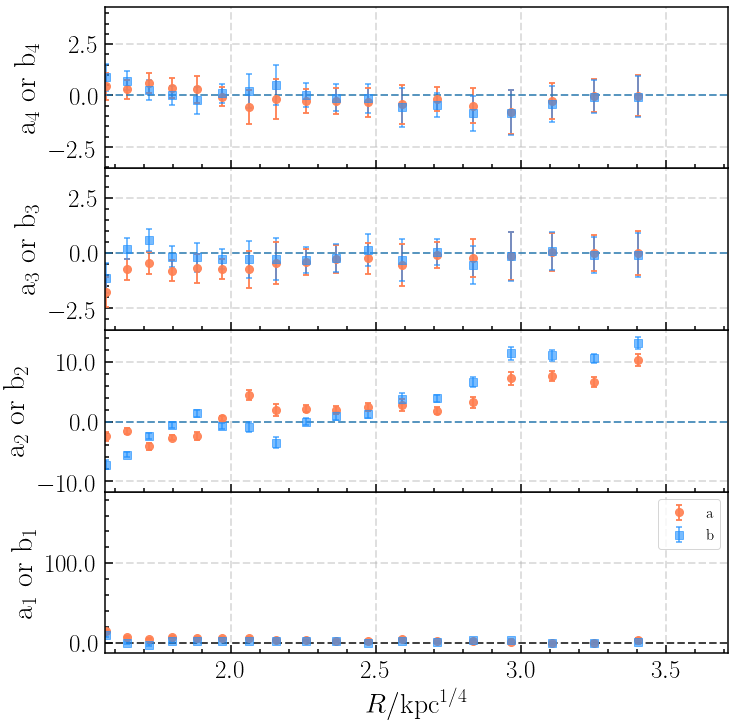

In [37]:
# You can also visualize the 1-D profiles of Fourier deviations for a certain profile

_ = visual.plot_ell_fourier(xy_sum['prof']['ins_mprof'], show_both=True)